<a href="https://colab.research.google.com/github/DrMohamedElsherif/CNNmodel-ImageClassification/blob/main/AutoEncoders_MNIST_%2B_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder and VAE

##### <span style="color:blue">**MOHAMED ELSHERIF**</span>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

<span style="color:red">If the code below prints 'cpu' as the device, training will be very slow. If you do not have access to a hardware-acceletated device (CUDA for NVIDIA graphics card or MPS for apple devices), consider running the notebook in google colab.</span>

In [ ]:
# Check if CUDA or MPS is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [ ]:
def set_seed_(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if device == 'mps':
        if torch.backends.mps.is_available():
            torch.mps.manual_seed(seed)
    elif device == 'cuda':
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)

seed = 42
set_seed_(seed)

# Data Processing

I would like to train an AutoEncoder to denoise handwritten digits. First I create the training and testing dataset.

In [ ]:
# Load the MNIST dataset
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

# Extract the data and add noise
train_data_clean = train_data.data.unsqueeze(1).float() / 255.0  # Normalize to [0, 1] range
test_data_clean = test_data.data.unsqueeze(1).float() / 255.0

# Define the noise function
def add_noise(img, noise_factor=0.4):
    """Adds random noise to an image."""
    noisy_img = img + noise_factor * torch.randn_like(img)
    return torch.clamp(noisy_img, 0.0, 1.0)

train_data_noisy = add_noise(train_data_clean)
test_data_noisy = add_noise(test_data_clean)

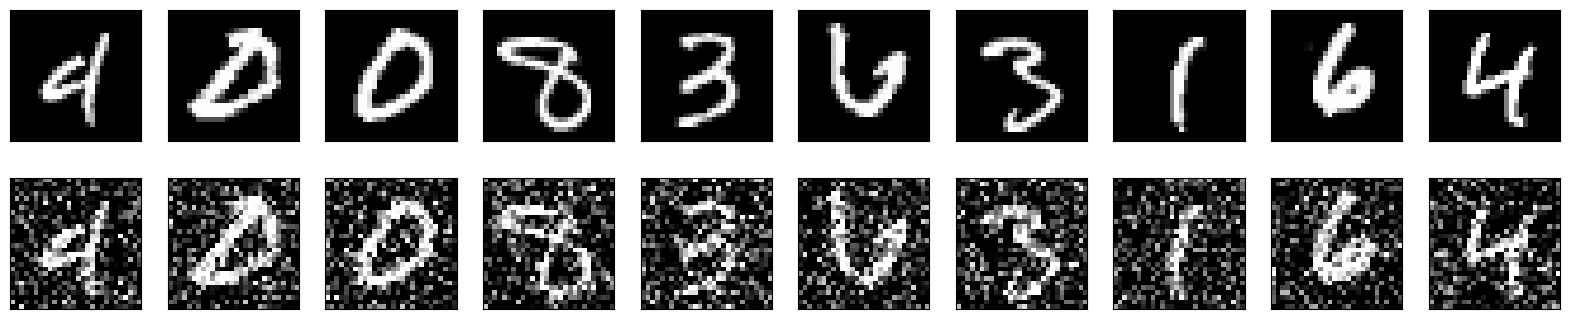

In [ ]:
# Define the display function
def display(array1, array2):
    """Displays ten random images from each array."""
    n = 10
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.squeeze().numpy(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.squeeze().numpy(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

# Display the train data and a version of it with added noise
display(train_data_clean, train_data_noisy)

In [ ]:
# Convert numpy arrays to PyTorch tensors
train_data_clean = train_data_clean.to(device)
test_data_clean = test_data_clean.to(device)
train_data_noisy = train_data_noisy.to(device)
test_data_noisy = test_data_noisy.to(device)

num_epochs = 10
batch_size = 128

# Define the data loaders
train_dataset = torch.utils.data.TensorDataset(train_data_noisy, train_data_clean)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(test_data_noisy, test_data_clean)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_dataset_with_labels = torch.utils.data.TensorDataset(train_data_clean, train_data.targets)
train_loader_with_labels= torch.utils.data.DataLoader(train_dataset_with_labels, batch_size=batch_size, shuffle=False)

# Training a Denoising Autoencoder

Now I specify the AutoEncoder model that I use for denoising. It will take as input a corrupted image, encode it into a latent space, and then decode it back into a reconstructed image that will be regressed onto the denoised image.

#### <span style="color:red"></span> Implement the Autoencoder architecture
I will use the following structure:

Encoder:
- Conv(32 output channels, kernel_size 3, padding 1)
- ReLU
- MaxPool(stride 2, padding 0)
- Conv(64 output channels, kernel size 3, padding 1)
- ReLU
- MaxPool(stride 2, padding 0)
- Flatten
- Fully connected(hidden_dim output neurons)
- ReLU
- Fully connected(latent_dim output neurons)

Decoder:
- Fully connected(hidden_dim output neurons)
- ReLU
- Fully connected(64*7*7 output neurons)
- ReLU
- Unflatten (output shape (64,7,7))
- ConvTranspose(32 output channels, kernel_size 3, stride 2, input_padding 1, output_padding 1)
- ReLU
- ConvTranspose(64 output channels, kernel_size 3, stride 2, input_padding 1, output_padding 1)
- Sigmoid

Hint: For the ConvTranspose I use nn.ConvTranspose2d

In [ ]:
# Define the Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim=64):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 64 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), # ConvTranspose(32 output channels, kernel_size 3, stride 2, input_padding 1, output_padding 1)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # ConvTranspose(64 output channels, kernel_size 3, stride 2, input_padding 1, output_padding 1)
            nn.Sigmoid()
        )


    def forward(self, x):
        latent_vector = self.encoder(x)
        reconstructed = self.decoder(latent_vector)
        return reconstructed, latent_vector

    def compute_loss(self, x, x_target):
        forward_return = self.forward(x)
        reconstructed, _ = forward_return
        criterion = nn.BCELoss(reduction='sum')
        loss = criterion(reconstructed, x_target)
        return loss, forward_return

In [ ]:
# Initialize the autoencoder model
ae_model = Autoencoder(latent_dim=2).to(device)

Next, I specify the training loop:

#### <span style="color:red"></span> Implement the training loop
I use the model.compute_loss function.

In [ ]:
def train_model(model, train_loader, lr, num_epochs):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        for data in train_loader:
            img_noisy, img = data
            img_noisy, img = img_noisy.to(device), img.to(device)


            # Forward pass
            loss, _ = model.compute_loss(img_noisy, img)
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


        # Print loss every epoch
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [ ]:
# Training the Model
# (Note: loss will look very large on the order of 10^4, this is not an issue.)
train_model(ae_model, train_loader, lr=0.0003, num_epochs=num_epochs)

Epoch [1/10], Loss: 17494.3652
Epoch [2/10], Loss: 17577.9922
Epoch [3/10], Loss: 17644.7344
Epoch [4/10], Loss: 16622.4688
Epoch [5/10], Loss: 16830.7539
Epoch [6/10], Loss: 15188.8438
Epoch [7/10], Loss: 15780.0566
Epoch [8/10], Loss: 15847.2734
Epoch [9/10], Loss: 15585.3750
Epoch [10/10], Loss: 15060.6582


For qualitative testing, I simply display pairs of corrupted and reconstructed images:

In [ ]:
def test_model(model, test_loader):
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            img_noisy, img = data
            img_noisy, img = img_noisy.to(device), img.to(device)
            output, _ = model(img_noisy)
            display(img_noisy.cpu(), output.cpu())
            break  # Display only the first batch

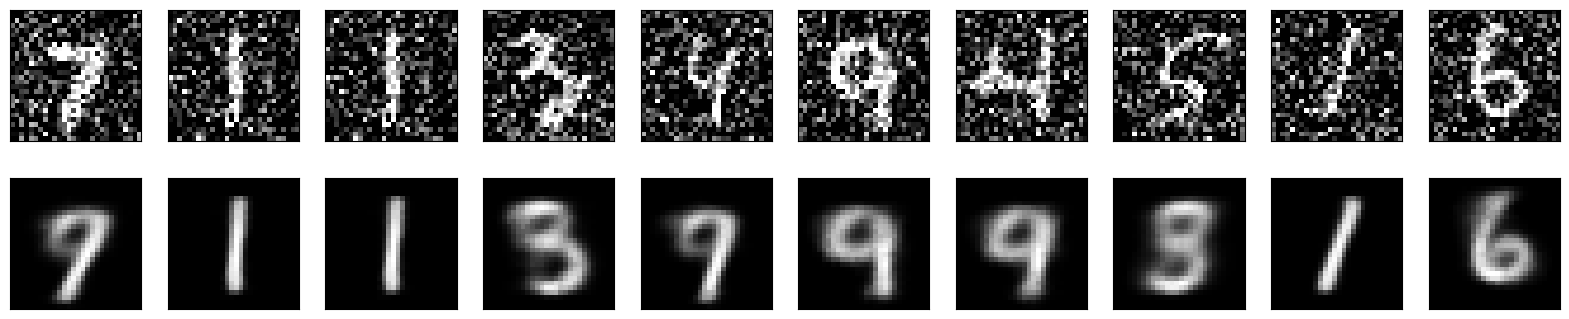

In [ ]:
# Testing the model
test_model(ae_model, test_loader)


<div style="background-color: yellow;">
    
**I observed reconstruction errors as follows:**
- 7 was wrongly reconstructed as 9
- 4 was wrongly reconstructed as 9
- 5 was wrongly resonstructed as 8

</div>


Next I initialize a new model with larger latent dimension and train it.


Epoch [1/10], Loss: 14858.5791
Epoch [2/10], Loss: 11229.0332
Epoch [3/10], Loss: 10615.1035
Epoch [4/10], Loss: 10182.6973
Epoch [5/10], Loss: 9168.5645
Epoch [6/10], Loss: 9199.9072
Epoch [7/10], Loss: 8599.1670
Epoch [8/10], Loss: 8797.2207
Epoch [9/10], Loss: 8268.4072
Epoch [10/10], Loss: 8158.7158


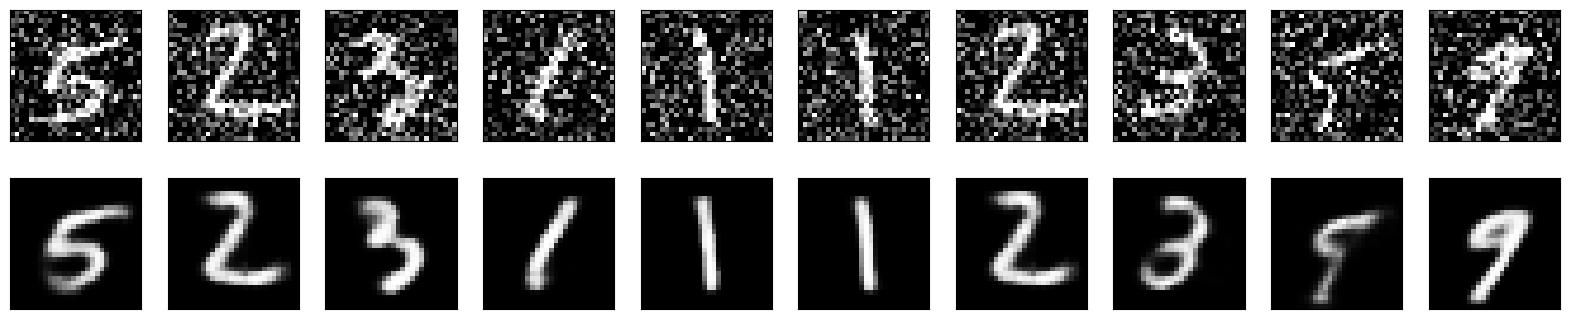

In [ ]:
ae_model_large = Autoencoder(latent_dim=16).to(device)
train_model(ae_model_large, train_loader, lr=0.0003, num_epochs=num_epochs)
test_model(ae_model_large, test_loader)

<div style="background-color: yellow;">
    
**Notice that Increasing latent dimentsion has eliminated/corrected errors in reconstruction**

</div>

# Autoencoder as a Generative Model

What else can we do with the autoencoder?
Because we have access to the latent space, we can investigate if we can use it to generate new images of handwritten digits.
First, I will try to interpolate between the latent representation of pairs of encoded images, and check what the decoded images look like.

In [ ]:
# Function to interpolate in the latent space
def interpolate_latent_space(model, dataset, n_steps=10, n_samples=5):
    """
    Displays a grid of images obtained by linearly interpolating between the latent vectors
    Each row corresponds to interpolating between the leftmost and rightmost images in the row
    """
    model.eval()
    with torch.no_grad():
        latent_vectors = []
        for i in range(n_samples+1):
            img = dataset[i].unsqueeze(0).to(device)
            _, latent = model(img)
            latent_vectors.append(latent)

        interpolated_images = []
        for i in range(n_samples):
            for alpha in np.linspace(0, 1, n_steps):
                interpolated_latent = latent_vectors[i] * (1 - alpha) + latent_vectors[i+1] * alpha
                decoded_image = model.decoder(interpolated_latent)
                interpolated_images.append(decoded_image)

        # Display in a grid
        fig, axes = plt.subplots(nrows=n_samples, ncols=n_steps, figsize=(20, n_samples*2))
        for i, ax in enumerate(axes.flat):
            image = interpolated_images[i].squeeze().cpu().numpy()
            ax.imshow(image, cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        plt.show()

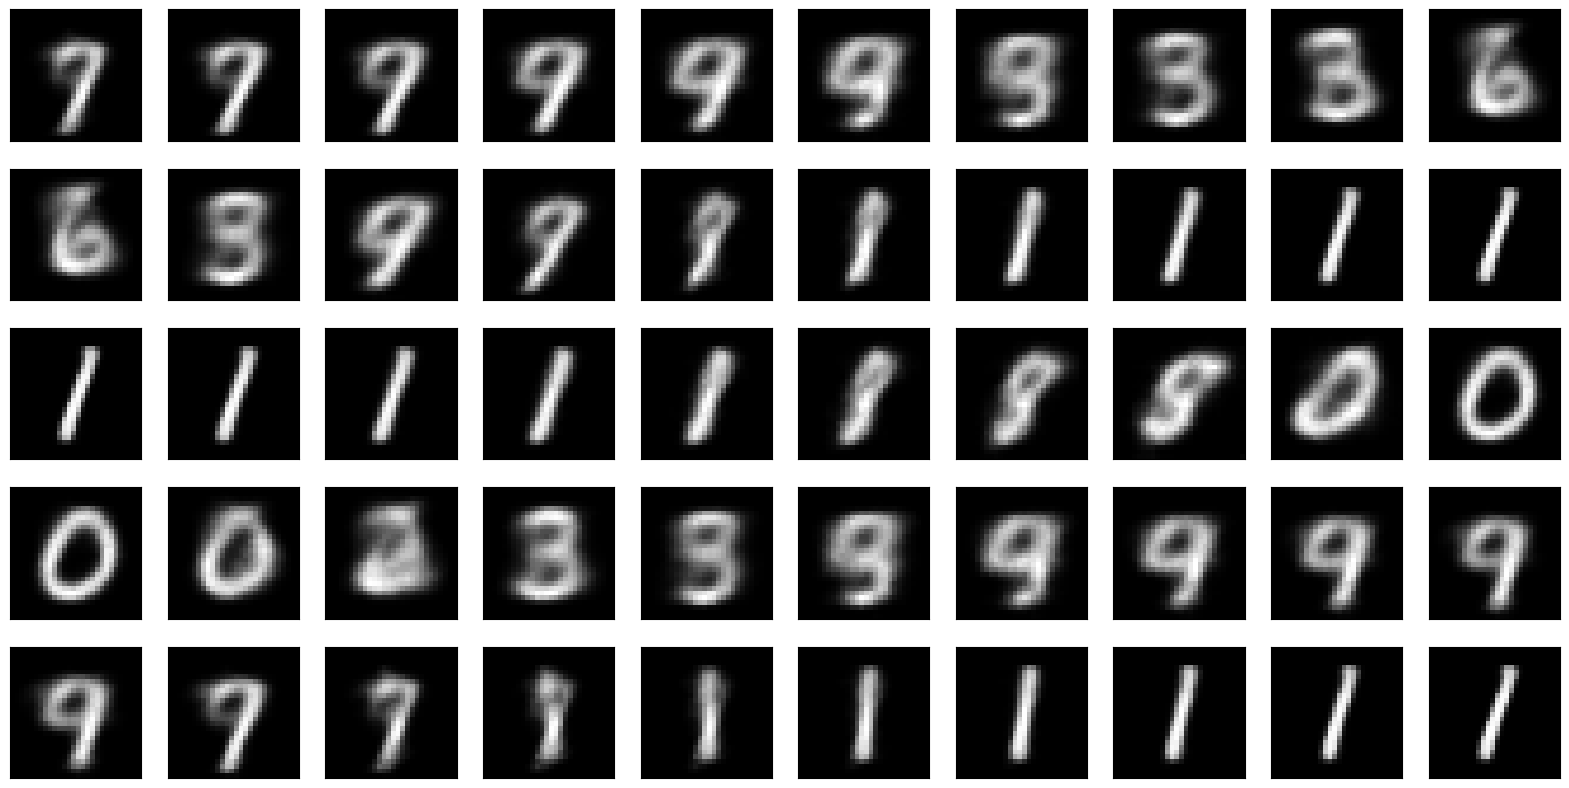

In [ ]:
# Interpolate between digits in the latent space
interpolate_latent_space(ae_model, dataset=test_data_clean)

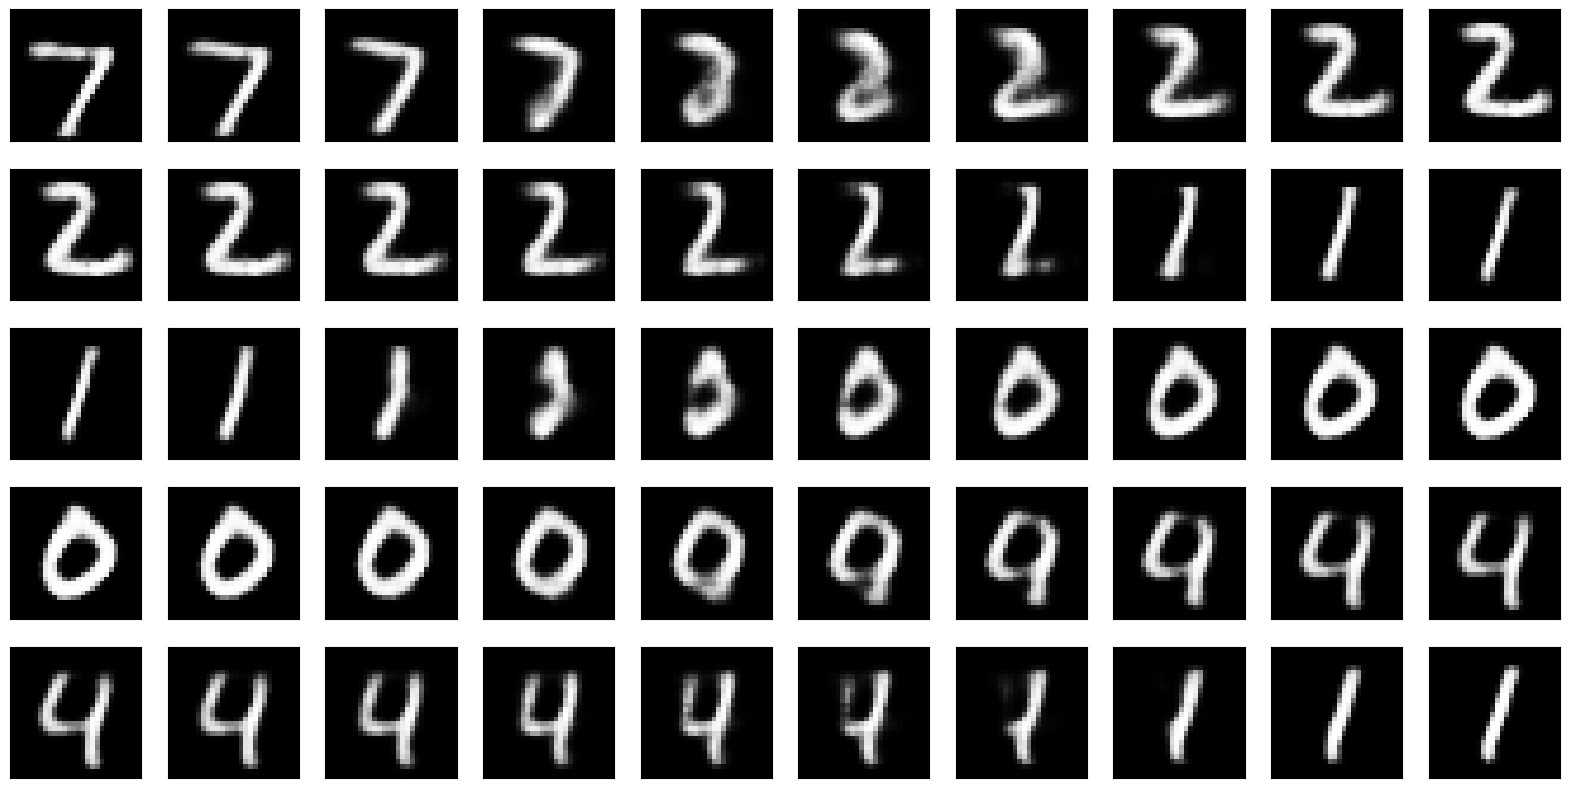

In [ ]:
interpolate_latent_space(ae_model_large, dataset=test_data_clean)


<div style="background-color: yellow;">
    
**Here I observe that Interporated images from the larger dimension model are smother and less noisy than those from the lower dimension model. My intuition is that higher-dimensional latent space can capture more complex patterns and nuances in the data, leading to better reconstructions and interpolations.**

</div>

Next, i draw random samples from the latent space and decode those:

#### <span style="color:red"></span> Design the sample_latent_space function.
This function will Draw n_samples latent_vector samples from a normal distribution and decode them into images.

In [ ]:
# Function to randomly sample from the latent space and show the decoded images
def sample_latent_space(model, n_samples=10):
    model.eval()
    with torch.no_grad():

        decoded_images = model.decoder(torch.randn(n_samples, model.latent_dim).to(device))


        plt.figure(figsize=(20, 4))
        for i, image in enumerate(decoded_images):
            ax = plt.subplot(1, n_samples, i + 1)
            plt.imshow(image.squeeze().cpu().numpy(), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        plt.show()

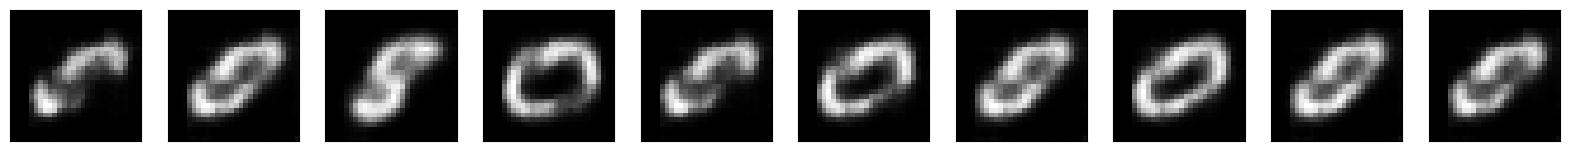

In [ ]:
# Randomly sample from the latent space and show the decoded images
sample_latent_space(ae_model)

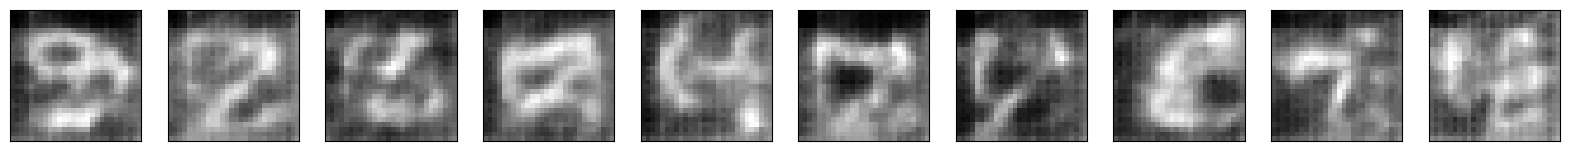

In [ ]:
sample_latent_space(ae_model_large)

<div style="background-color: yellow;">
    
**Sampled images from the smaller dimension space shows hazy appearing digits in a constraint black background, while the sampled images from the larger dimention space shows hazy dispersed ill-defined shapes melted over larger area appearing as ground-glass white background. This can occur because the larger model has a higher capacity and is attempting to capture a wide range of variations within the latent space.**

Lets confirm my intuition by visualizing the two-dimensional latent space of the smaller autoencoder.

In [ ]:
# Function to visualize the latent space
def visualize_latent_space(model, loader_with_labels, n_points=1000):
    if model.latent_dim != 2:
        return

    model.eval()
    latents = []
    labels = []
    with torch.no_grad():
        for data in loader_with_labels:
            img, label = data
            img = img.to(device)
            _, latent = model(img)
            latents.append(latent.cpu())
            labels.append(label)

    latents = torch.cat(latents)[:n_points]
    labels = torch.cat(labels)[:n_points]

    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, ticks=range(10))
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('Latent Space Visualization')
    plt.show()

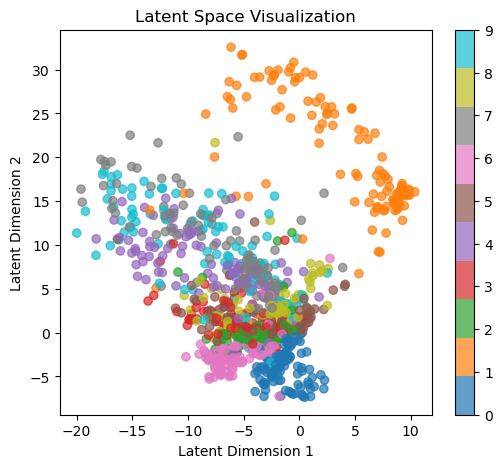

In [ ]:
# Visualize the latent space
visualize_latent_space(ae_model, loader_with_labels=train_loader_with_labels)



<div style="background-color: yellow;">

**The visualization reveals distinct and well-separated clusters for digit '1'. In contrast, clusters corresponding to other digits exhibit considerable overlap, indicating a lack of clear differentiation in the latent space representation. This confirms my intuition.**
</div>


To resolve some of the observed issues, I will now regularize the latent space, which leads us to the variational autoencoder.

# Variational Autoencoder (VAE)

In the variational autoencoder, instead of predicting a deterministic latent vector, the encoder predicts the mean and variance of a distribution over latent vectors. Intuitively, this increases the number of latent vectors that the decoder "sees" during training, and therefore makes it produce a sensible (handwritten digit) output for more latent inputs. However, intuitively the encoder could simply learn a variance of zero or a mean that is far away from zero, such that random samples of a latent vector around zero would still lead to a meaningless output of the decoder. To prevent this, an additional loss term is added that penalizes how much the learned distribution predicted by the encoder differs from a zero mean unit variance normal distribution.

#### <span style="color:red"></span> Implement the VAE architecture

I will use the same structure as for the VAE, except that for the encoder, after the flattening, there are now two MLP heads instead of one. One MLP head predicts the mean of the latent distribution and the other one predicts the log-variance. Both follow the same structure as the MLP head in the previous autoencoder.

Additionally, I implement the sampling function. If we would directly sample from the distribution predicted by the encoder, this sampling step would not be differentiable and it would break our computational graph for backpropagation. Therefore, I use the so-called "reparameterization trick". This means, that we can get the same samples by first sampling from a zero-mean unit-variance normal distribution, and then in a second step scaling these samples by the predicted standard deviation and adding them to the predicted mean. The resulting samples now follow the same distribution, but now the sampling part does not break the computational graph. My reference to my approach technique is here: https://snawarhussain.com/blog/genrative%20models/python/vae/tutorial/machine%20learning/Reparameterization-trick-in-VAEs-explained/

In [ ]:
# Define the Variational Autoencoder model
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim=64):
        super(VariationalAutoencoder, self).__init__()
        self.latent_dim = latent_dim


        # Encoder
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # 1 input channel (grayscale), 32 output channels
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # 32 input channels, 64 output channels
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.encoder_fc_mu = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )

        self.encoder_fc_logvar = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 64*7*7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),  # Reshape to match the expected shape for convolutional layers
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )


    def sample(self, mu, logvar):
        """Uses the reparameterization trick to sample from the latent space."""
        # Compute the standard deviation from the log variance
        std = torch.exp(0.5 * logvar)
        # Sample from the standard normal distribution
        epsilon = torch.randn_like(std)
        # Get the latent vector z
        z = mu + epsilon * std
        return z

    def forward(self, x, return_logvar=False):
        x = self.encoder_conv(x)
        x = x.view(x.size(0), -1)
        mu = self.encoder_fc_mu(x)
        logvar = self.encoder_fc_logvar(x)
        z = self.sample(mu, logvar)
        reconstructed = self.decoder(z)
        if return_logvar:
            return reconstructed, mu, logvar
        else:
            return reconstructed, mu

    def compute_loss(self, x, x_target):
        forward_return = self.forward(x, return_logvar=True)
        reconstructed, mu, logvar = forward_return
        criterion = nn.BCELoss(reduction='sum')
        reconstruction_loss = criterion(reconstructed, x_target)
        # Kullback-Leibler divergence between two Gaussian distributions has closed-form solution
        kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = reconstruction_loss + kld_loss
        return loss, forward_return

I first train a VAE with a 2-dimensional latent space to allow visualization of the latent space.

Train the VAE model
Epoch [1/10], Loss: 17380.0703
Epoch [2/10], Loss: 15730.5020
Epoch [3/10], Loss: 15719.2168
Epoch [4/10], Loss: 15210.1846
Epoch [5/10], Loss: 15332.8252
Epoch [6/10], Loss: 14996.6631
Epoch [7/10], Loss: 15387.6514
Epoch [8/10], Loss: 14912.4326
Epoch [9/10], Loss: 15242.0840
Epoch [10/10], Loss: 15634.5078
Test the VAE model


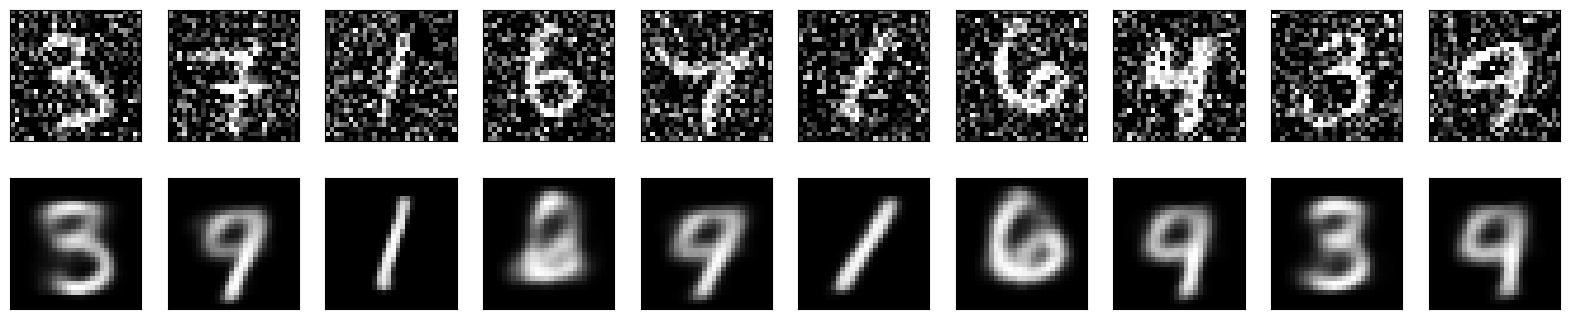

Interpolate in the latent space


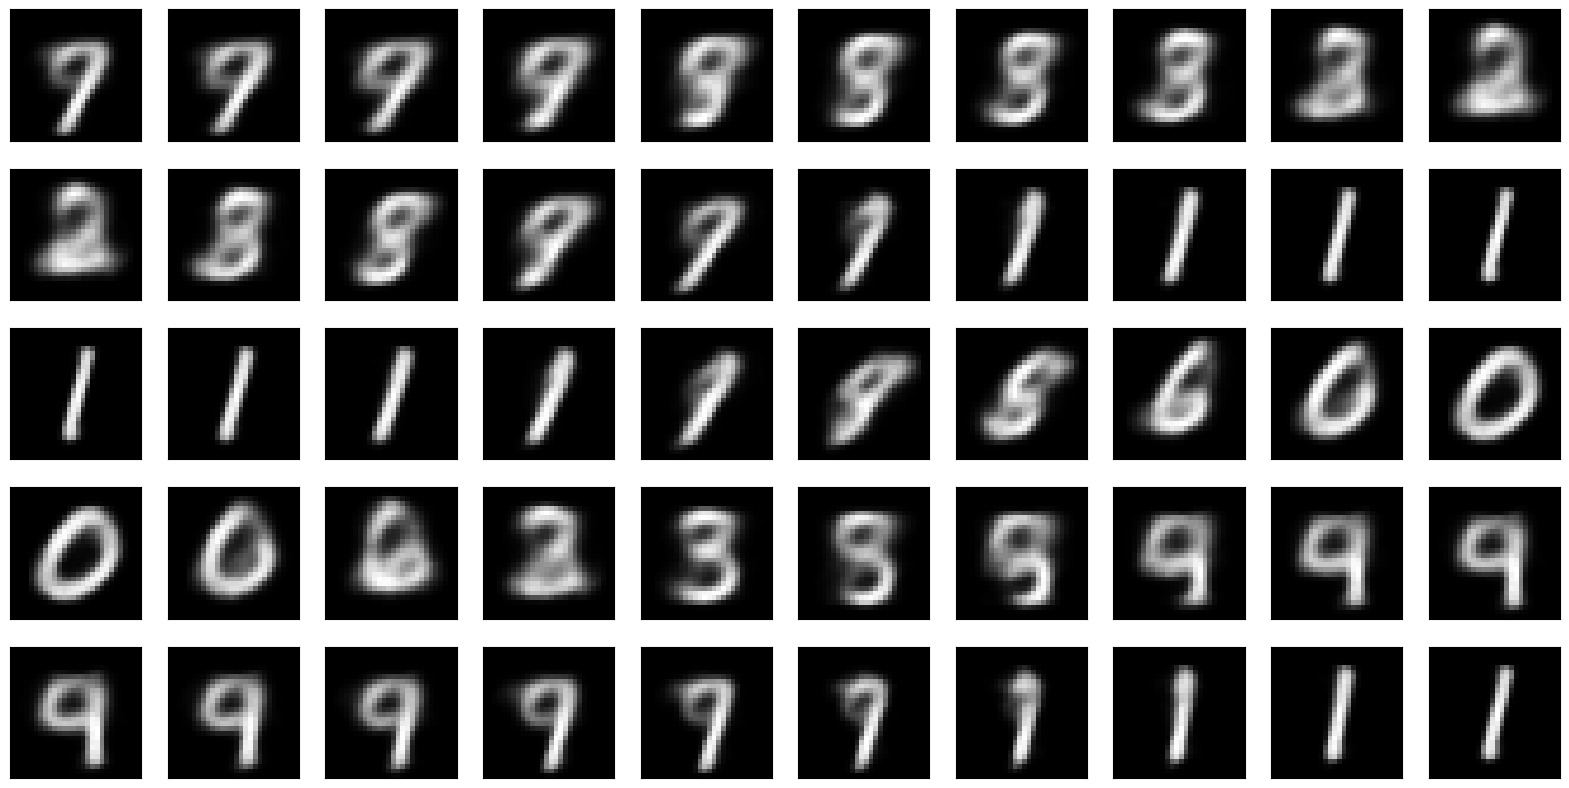

Sample from the latent space


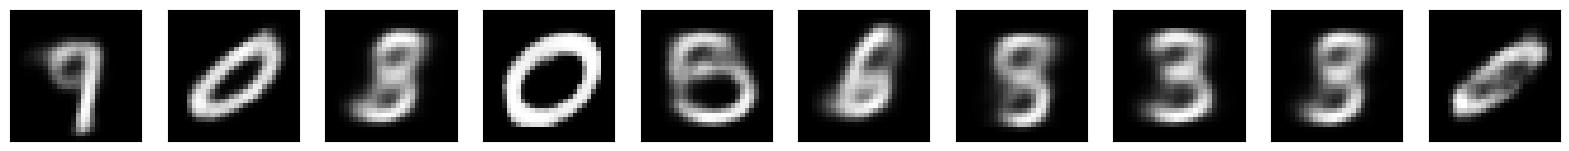

Visualize the latent space


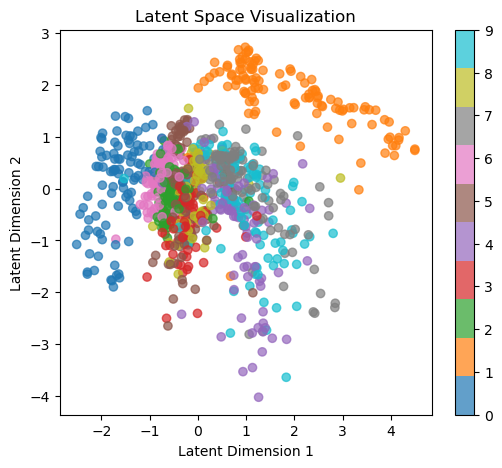

In [ ]:
vae_model = VariationalAutoencoder(latent_dim=2).to(device)
print('Train the VAE model')
train_model(vae_model, train_loader, lr=0.0003, num_epochs=num_epochs)
print('Test the VAE model')
test_model(vae_model, test_loader)
print('Interpolate in the latent space')
interpolate_latent_space(vae_model, dataset=test_data_clean)
print('Sample from the latent space')
sample_latent_space(vae_model)
print('Visualize the latent space')
visualize_latent_space(vae_model, loader_with_labels=train_loader_with_labels)

<div style="background-color: yellow;">
    
**Now notice that the application of a Variational Autoencoder (VAE) has resulted in the formation of more distinct clusters corresponding to different digit classes compared to plain autoencoder**

</div>

Next, I try to use the VAE with a higher latentent dimension.

Train the VAE model
Epoch [1/10], Loss: 19279.5605
Epoch [2/10], Loss: 18080.0820
Epoch [3/10], Loss: 15101.5391
Epoch [4/10], Loss: 14755.1357
Epoch [5/10], Loss: 14091.9678
Epoch [6/10], Loss: 14748.2324
Epoch [7/10], Loss: 14435.5547
Epoch [8/10], Loss: 13927.1670
Epoch [9/10], Loss: 13556.6738
Epoch [10/10], Loss: 14296.3496
Test the VAE model


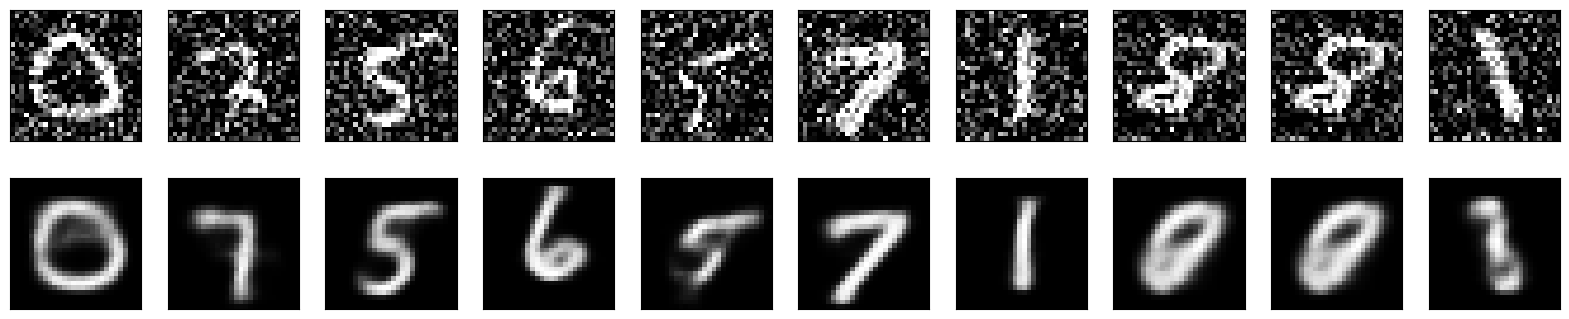

Interpolate in the latent space


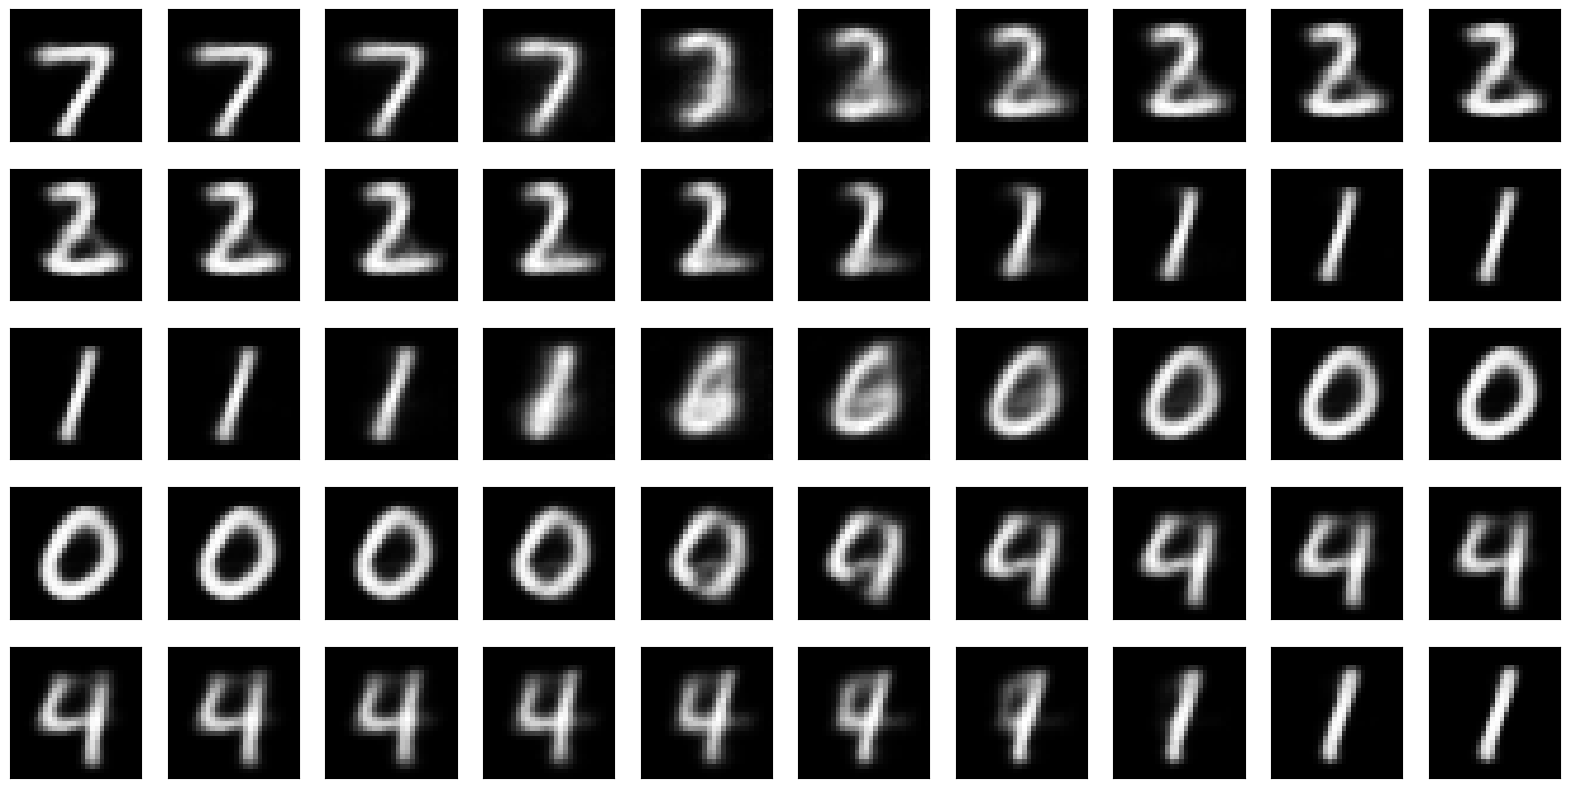

Sample from the latent space


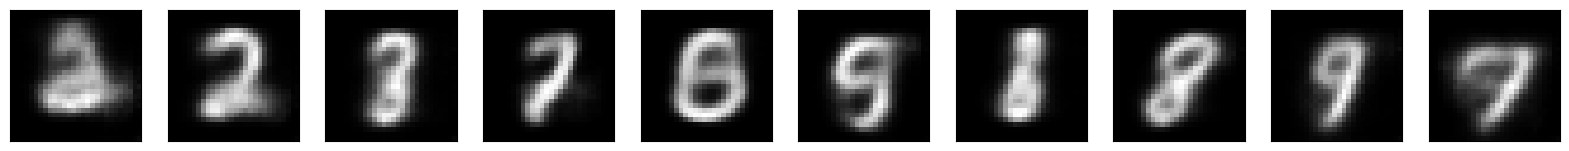

Visualize the latent space


In [ ]:
vae_model = VariationalAutoencoder(latent_dim=64).to(device)
print('Train the VAE model')
train_model(vae_model, train_loader, lr=0.0003, num_epochs=num_epochs)
print('Test the VAE model')
test_model(vae_model, test_loader)
print('Interpolate in the latent space')
interpolate_latent_space(vae_model, dataset=test_data_clean)
print('Sample from the latent space')
sample_latent_space(vae_model)
print('Visualize the latent space')
visualize_latent_space(vae_model, loader_with_labels=train_loader_with_labels)


<div style="background-color: yellow;">
    
**The enhancement of the VAE latent space capacity has resulted in significantly improved image clarity. Random sampling within this enhanced latent space now yields realistic representations of handwritten digits, as opposed to the outputs generated by a standard autoencoder.**

# Changing to Fashion MNIST

#### <span style="color:red"></span> Switching to Fashion: Now let's Train a VAE on the Fashion MNIST dataset and see what we get!

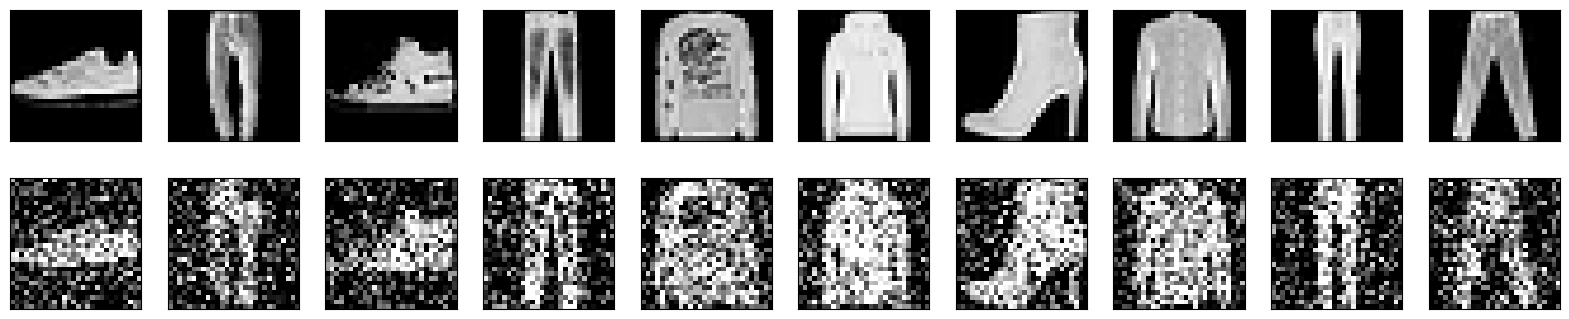

Training the VAE model on Fashion MNIST...
Epoch [1/10], Loss: 26055.1191
Epoch [2/10], Loss: 25580.2852
Epoch [3/10], Loss: 25211.4746
Epoch [4/10], Loss: 25078.4492
Epoch [5/10], Loss: 25623.3008
Epoch [6/10], Loss: 24723.4297
Epoch [7/10], Loss: 24239.7832
Epoch [8/10], Loss: 23977.0020
Epoch [9/10], Loss: 22534.4941
Epoch [10/10], Loss: 21915.4746
Testing the VAE model...


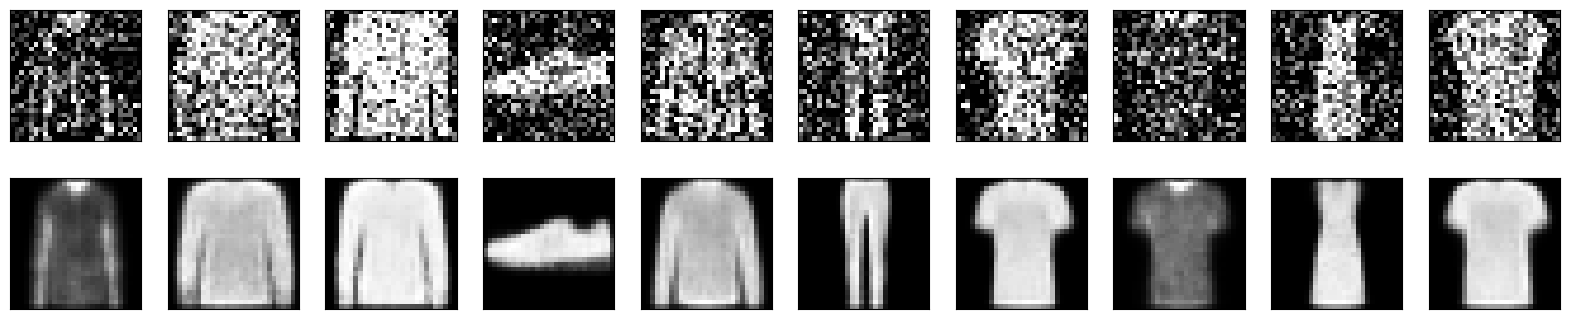

Interpolate in the latent space


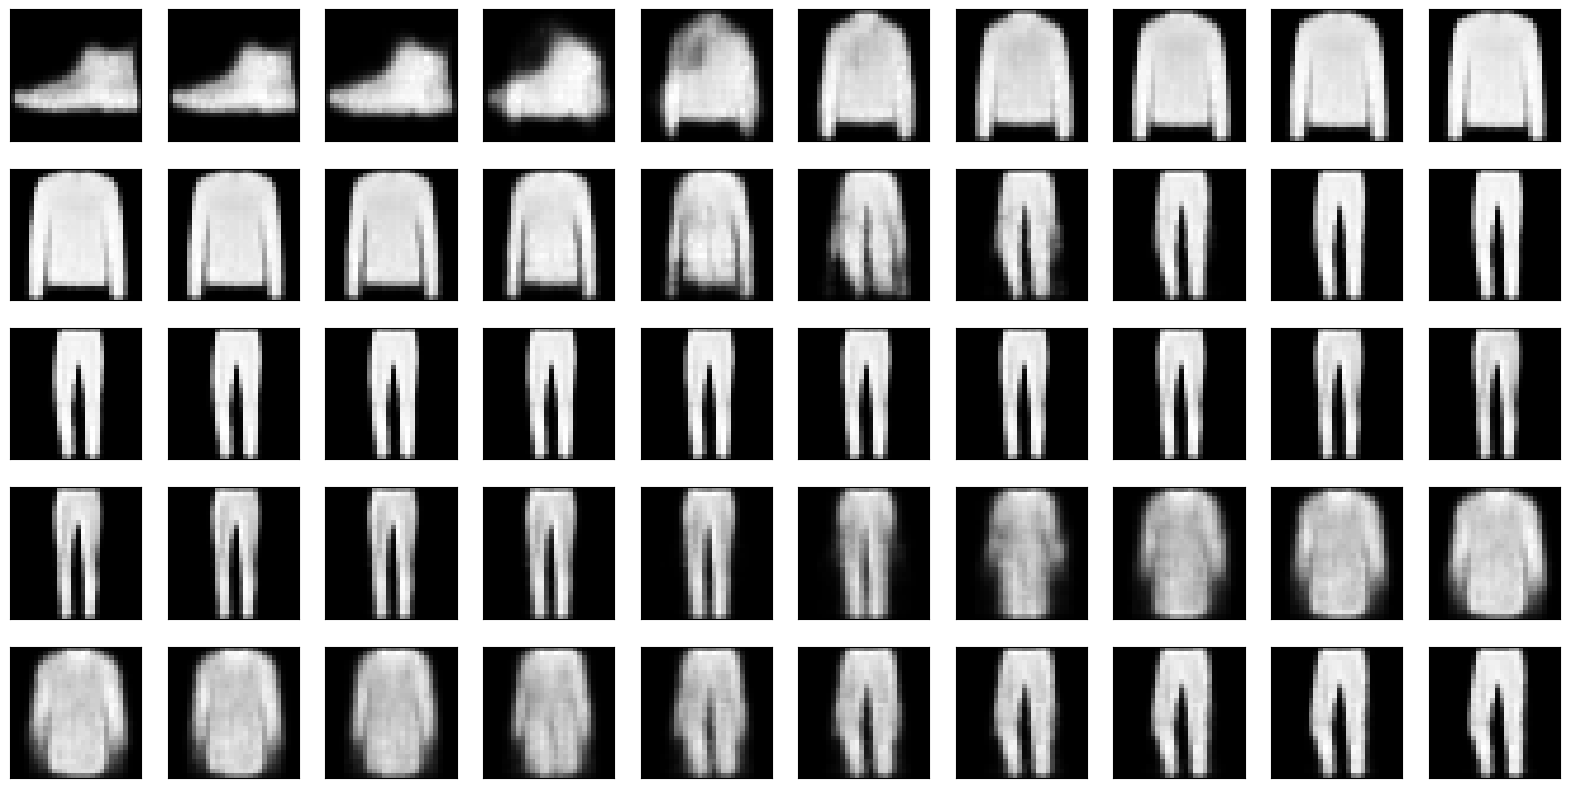

Sample from the latent space


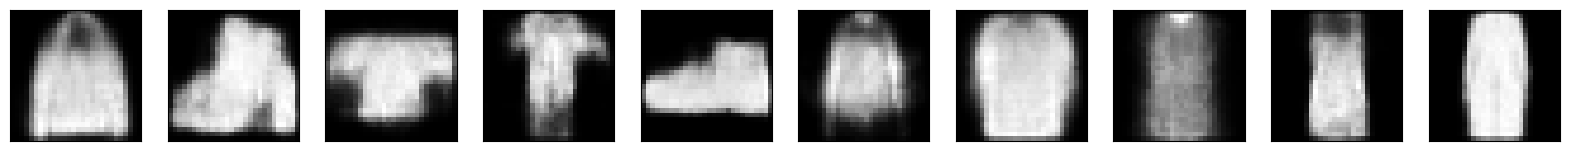

Visualize the latent space


In [ ]:
# Load the Fashion MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Extract data and add noise
train_data_clean = train_data.data.unsqueeze(1).float() / 255.0  # Normalize to [0, 1] range
test_data_clean = test_data.data.unsqueeze(1).float() / 255.0

train_data_noisy = add_noise(train_data_clean)
test_data_noisy = add_noise(test_data_clean)

# Display the train data and a version of it with added noise
display(train_data_clean, train_data_noisy)

# Convert numpy arrays to PyTorch tensors
train_data_clean = train_data_clean.to(device)
test_data_clean = test_data_clean.to(device)
train_data_noisy = train_data_noisy.to(device)
test_data_noisy = test_data_noisy.to(device)

num_epochs = 10
batch_size = 128

# Define the data loaders
train_dataset = torch.utils.data.TensorDataset(train_data_noisy, train_data_clean)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(test_data_noisy, test_data_clean)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the VAE model
vae_model = VariationalAutoencoder(latent_dim=20).to(device)

print('Training the VAE model on Fashion MNIST...')
train_model(vae_model, train_loader, lr=0.001, num_epochs=num_epochs)

print('Testing the VAE model...')
test_model(vae_model, test_loader)

print('Interpolate in the latent space')
interpolate_latent_space(vae_model, dataset=test_data_clean)
print('Sample from the latent space')
sample_latent_space(vae_model)
print('Visualize the latent space')
visualize_latent_space(vae_model, loader_with_labels=train_loader_with_labels)

<div style="background-color: yellow;">
    
**Here, I notice that the reconstructions of FASHION-MNIST exhibit more blurriness or lack of fine details compared to MNIST, which could be because images in FASHION-MNIST dataset are more complex and varied than MNIST**


### END OF MY SMALL PROJECT 👋